In [ ]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import cv2
# import the necessary packages
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

from plot_keras_history import plot_history

def get_encoding(series):
    #getting our classes
    array = series.to_numpy().reshape(-1,1)
    encoder = OneHotEncoder().fit(array)
    return encoder.transform(array).toarray(), encoder

def setup_keras_model(model, layers):
    for layer in layers:
        model.add(layer)
    
    print(model.summary())


def rmse(x,y):
    return sqrt(mean_squared_error(x,y))

    
def update_metrics(metric_df,df_test, preds, targets_str, metrics, model_name, input_features=None, epochs=10):    
    
    metric_df.loc[model_name, "input_features"] = input_features
    human_rows = df_test["class"] == "Pedestrian"
    metric_df.loc[model_name, "epochs"] = epochs
    hdf = df_test[human_rows]
    human_preds = [pred[human_rows] for pred in preds]
    
    #evaluate the targets
    for i, s in enumerate(targets_str):
        target = df_test[s]
        
        print(metrics[i](preds[i], target))
        metric = metrics[i](preds[i], target)
        metric_df.loc[model_name, f"{s}_{metrics[i].__name__}_total"] = metric
        
        #predict error for human targets only
        target = hdf[s]
        metric = metrics[i](human_preds[i], target)
        metric_df.loc[model_name, f"{s}_{metrics[i].__name__}_human"] = metric  
    

def save_model(model, model_dir, model_name):
    model_json = model.to_json()
    with open(f"{model_dir}/{model_name}.json", "w") as json_file:
        json_file.write(model_json)

    model.save_weights(f"{model_dir}/{model_name}.h5")
    print("Saved model to disk")



# update_metrics(metric_df, df_test["dist_feet"], df_test, "foo")

# Initiazling GPU

In [4]:
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)


gpus

W0000 00:00:1734219432.550584  373685 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[]

# Sequential Generator
Needed cause the just loading all the images into ram overloads it and crashes jupyter.

In [3]:
#used because too many images
class My_Custom_Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size, img_dir):
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.img_dir = img_dir
    
  def __len__(self):
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    return np.array([
            cv2.imread(img_dir + str(file_name))
               for file_name in batch_x])/255.0, np.array(batch_y)

# Functional API Generator

In [4]:
#used because too many images
class functional_api_generator(tf.keras.utils.Sequence):
  def __init__(self, df: pd.DataFrame, filenames: pd.Series, input_features: {str: [str],},
               output_features: {str: [str],}, batch_size: int, img_dir: str):
    self.df = df
    #encoders
    self.encoders = {}
    
    self.input_features = self.parse_features(input_features)
    self.output_features = self.parse_features(output_features)
    
    
        
    #filenames
    self.image_filenames = filenames
    
    #miscelaneous
    self.batch_size = batch_size
    self.img_dir = img_dir
    


    
  def __len__(self):
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)
  
  
  def __getitem__(self, idx):
    

    start = idx * self.batch_size
    stop = (idx+1) * self.batch_size

    
    input_batch = {key: value[start:stop] for key, value in self.input_features.items()}
    output_batch = {key: value[start:stop] for key, value in self.output_features.items()}
    
    
    input_batch["img"] = np.array([cv2.imread(img_dir + str(file_name)) 
                                    for file_name in self.image_filenames[start:stop]])
    return input_batch, output_batch

  def parse_series(self, series):
    return get_encoding(series)[0] if series.dtype == object else series.values.reshape(-1,1)

  def parse_dataframe(self, df):
    values = []
    for key in df.columns:
        series = self.parse_series(df[key])
        values.append(series)
    
    return np.hstack(values)
    


  def parse_features(self, features):     
    features_w_data = {}
    for layer_key, df_key in features.items():
        data = self.df[df_key]
        
        if isinstance(data, pd.DataFrame):
            features_w_data[layer_key] = self.parse_dataframe(data)
                        
        elif isinstance(data, pd.Series):
            features_w_data[layer_key] = self.parse_series(data)
    
        
    return features_w_data

# Loading and Setting up DataFrames

In [5]:
#set up some directory names
global_dirname = "/home/jack/Desktop/code/projects/deloitte/cv_distance_estimation"
data_dir = f"{global_dirname}/data"
img_dir = f"/home/jack/Desktop/code/projects/deloitte/cv_distance_estimation/data/training/image_2_bounding/"
subimage_pos_dir = f"{data_dir}/training/subimages_padded_w_position"
subimage_no_pos_dir = f"{data_dir}/training/subimages_padded_no_position"

subimage_dir = f"{data_dir}/training/subimages"

model_dir = f"{global_dirname}/models/"

#load data
df = pd.read_csv(f"{data_dir}/labels.csv")

df_train, df_test = (pd.read_csv(f"{data_dir}/train.csv"), pd.read_csv(f"{data_dir}/test.csv"))

df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

img_metric_df = pd.DataFrame()

metric_df = pd.read_csv(f"{data_dir}/metrics/metric_df_bb_only.csv", index_col=0)

# Training Parameters

In [6]:
#choosing how many rows to train with
# n = 300
n = df_train.shape[0]

df_train = df_train.head(n)
df_test = df_test.head(n)

epochs = 50
verbose = 2
batch_size = 10

# train_class, class_encoder = get_encoding(df_train["class"])
train_class, class_encoder = get_encoding(df_train["class"])
test_class, class_encoder = get_encoding(df_test["class"])

class_shape_train = train_class[0].shape
class_shape_test = test_class[0].shape



#angle output encodings
# train_angle = get_encoding(df_train.angle_discrete)[0]
train_angle, angle_encoder = get_encoding(df_train.angle_discrete)
test_angle, class_encoder = get_encoding(df_test.angle_discrete)

angle_shape_train = train_angle[0].shape
angle_shape_test = test_angle[0].shape

angle_shape = train_class[0].shape


print(class_shape_train, class_shape_test)
print(angle_shape_train, angle_shape_test)

(8,) (8,)
(8,) (8,)


# Setting up batch generators for images

In [7]:
#initializing generators
my_training_batch_generator = My_Custom_Generator(df_train["filename_bb"],
                                                  df_train["dist_feet"], batch_size, img_dir)

my_testing_batch_generator = My_Custom_Generator(df_test["filename_bb"],
                                                 df_test["dist_feet"], batch_size, img_dir)

# Get model input shape

In [8]:
#setting up image directroy where the images will be coming from
file = f"{img_dir}/0.png"

image_shape = cv2.imread(file).shape

#subimage_shape with position
file = f"{subimage_pos_dir}/0.png"
subimage_pos_shape = cv2.imread(file).shape

#subimage shape without position
file = f"{subimage_no_pos_dir}/0.png"
subimage_no_pos_shape = cv2.imread(file).shape

In [20]:
print(image_shape, subimage_pos_shape, subimage_no_pos_shape)

(94, 310, 3) (94, 310, 3) (93, 127, 3)


# Image with Bounding Box Only Training

In [21]:
#Model pathing and file names
model_name = "img_w_bb_only"

#_________________________________________Model Training
model = keras.models.Sequential()


layers = [keras.layers.Conv2D(500, kernel_size=3, activation="relu", input_shape=image_shape),
         keras.layers.AveragePooling2D(),
         keras.layers.Conv2D(250, kernel_size=3, activation="relu"),
         keras.layers.AveragePooling2D(),
         keras.layers.Flatten(),
         keras.layers.Dense(100, activation="relu"),
         keras.layers.Dense(32, activation="relu"),
         keras.layers.Dense(1)]


setup_keras_model(model, layers)


model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=0.00001),         )

history = model.fit(my_training_batch_generator, validation_data=my_testing_batch_generator,
                    batch_size=32, epochs=epochs, verbose=2)



save_model(model, f"{model_dir}/models", model_name)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 92, 308, 500)      14000     
                                                                 
 average_pooling2d_2 (Averag  (None, 46, 154, 500)     0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 44, 152, 250)      1125250   
                                                                 
 average_pooling2d_3 (Averag  (None, 22, 76, 250)      0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 418000)            0         
                                                                 
 dense_3 (Dense)             (None, 100)              

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>)

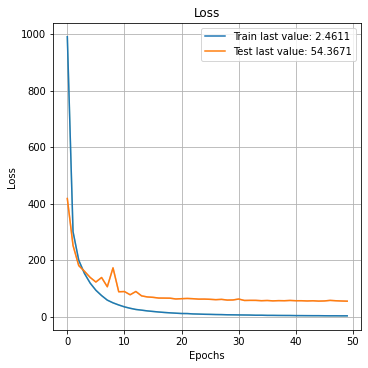

In [22]:
plot_history(history, path=f"{global_dirname}/results_history/{model_name}")

In [23]:
pred = model.predict(my_testing_batch_generator)
model_name = "img_w_bb_only"


print("foo")

update_metrics(img_metric_df,
               df_test, 
               [pred],
               ["dist_feet"],
               [rmse],
               model_name,
              epochs=epochs)

img_metric_df.to_csv(f"{data_dir}/metrics/model_metrics.csv")

img_metric_df

foo
7.373409057911393


,input_features,epochs,dist_feet_rmse_total,dist_feet_rmse_human
img_w_bb_only,NaN,50.0,7.373409,5.383458


# Image with Bounding Box and Class

## Getting inputs

In [16]:
#class encodings
# train_class, class_encoder = get_encoding(df_train["class"])
train_class, class_encoder = get_encoding(df_train["class"])
class_shape = test_class[0].shape

#angle output encodings
# train_angle = get_encoding(df_train.angle_discrete)[0]
test_angle, angle_encoder = get_encoding(df_train.angle_discrete)
angle_shape = test_angle[0].shape

#images already done
img_input = keras.Input(shape=image_shape, name="img")

#class input
class_input = keras.Input(shape=class_shape, name="class")

#subimage_input
subimage_pos_input = keras.Input(shape=subimage_pos_shape, name="img")

#subimage without position
subimage_no_pos_input = keras.Input(shape=subimage_no_pos_shape, name="img")

#relative position
position_input = keras.Input(shape=(4,), name="position")

In [17]:
print(subimage_pos_shape, subimage_no_pos_shape)

(94, 310, 3) (93, 127, 3)


# Generators for Img+class~Distance 

In [18]:

input_features_class = {"class": ["class"]}
output_features_dist = {"distance": ["dist_feet"]}



train_generator_dist = functional_api_generator(df_train, df_train["filename_bb"], input_features_class,
                                                 output_features_dist, batch_size, img_dir)

test_generator_dist = functional_api_generator(df_test, df_test["filename_bb"], input_features_class,
                                                 output_features_dist, batch_size, img_dir)

# generators for Img+class~distance+angle_discrete model


In [19]:
input_features_angle_discrete = {"class": ["class"]}
output_features_angle_discrete = {"distance": ["dist_feet"], "angle": ["angle_discrete"]}

train_generator_angle = functional_api_generator(df_train, df_train["filename_bb"], input_features_angle_discrete,
                                                 output_features_angle_discrete, batch_size, img_dir)

test_generator_angle = functional_api_generator(df_test, df_test["filename_bb"], input_features_angle_discrete,
                                                 output_features_angle_discrete, batch_size, img_dir)


# Generators for Img+class~Distance+trig_angle model


In [20]:
input_features_angle_trig = {"class": ["class"]}
output_features_angle_trig = {"distance": ["dist_feet"], "trig_angle": ["sin_angle", "cos_angle"]}

train_generator_trig = functional_api_generator(df_train, df_train["filename_bb"], input_features_angle_trig,
                                                 output_features_angle_trig, batch_size, img_dir)

test_generator_trig = functional_api_generator(df_test, df_test["filename_bb"], input_features_angle_trig,
                                                 output_features_angle_trig, batch_size, img_dir)

# Generators for Subimage_pos+Class~Distance+trig_angle

In [21]:
input_features_subimage = {"class": ["class"]}
output_features_angle_trig = {"distance": ["dist_feet"], "trig_angle": ["sin_angle", "cos_angle"]}

train_subimage_pos_trig_generator = functional_api_generator(df_train, df_train["filename_bb"], input_features_subimage,
                                                 output_features_angle_trig, batch_size, subimage_pos_dir)

test_subimage_pos_trig_generator = functional_api_generator(df_test, df_test["filename_bb"], input_features_subimage,
                                                 output_features_angle_trig, batch_size, subimage_pos_dir)


# Generators for Subimage_no_pos+Class~Distance+trig_angle

In [22]:
input_features_subimage = {"class": ["class"], "position": ["xmin", "xmax", "ymin","ymax"]}
output_features_angle_trig = {"distance": ["dist_feet"], "trig_angle": ["sin_angle", "cos_angle"]}

train_subimage_no_pos_trig_generator = functional_api_generator(df_train, df_train["filename_bb"], input_features_subimage,
                                                 output_features_angle_trig, batch_size, subimage_dir)

test_subimage_no_pos_trig_generator = functional_api_generator(df_test, df_test["filename_bb"], input_features_subimage,
                                                 output_features_angle_trig, batch_size, subimage_dir)

## Setup Model

In [23]:
#image layers
img_layer = keras.layers.Conv2D(500, kernel_size=3, activation="relu")(img_input)
img_layer = keras.layers.AveragePooling2D()(img_layer)
img_layer = keras.layers.Conv2D(250, kernel_size=3, activation="relu")(img_layer)
img_layer = keras.layers.AveragePooling2D()(img_layer)
img_layer = keras.layers.Flatten()(img_layer)



#class layers
class_layer = keras.layers.Dense(30, kernel_initializer='normal', activation='relu')(class_input)
class_layer = keras.layers.Dense(15, kernel_initializer='normal', activation='relu')(class_layer)
class_layer = keras.layers.Dense(8, kernel_initializer='normal', activation='relu')(class_layer)

#concatanate the two layers
combined_layer = keras.layers.concatenate([img_layer, class_layer])
combined_layer = keras.layers.Dense(100, activation="relu")(combined_layer)
combined_layer = keras.layers.Dense(32, activation="relu")(combined_layer)

#output layers
dist_layer = keras.layers.Dense(1, name="distance")(combined_layer)
angle_layer = keras.layers.Dense(angle_shape[0], name="angle")(combined_layer)
trig_angle_layer = keras.layers.Dense(2, name="trig_angle")(combined_layer)

# Distance Model Training and Evaluation

In [24]:
#defining full model
dist_model = keras.Model(
    inputs=[img_input, class_input],
    outputs=[dist_layer],
)
epochs=1000

In [33]:
model_name = "img_bb+class~dist_feet"

keras.utils.plot_model(dist_model, f"{global_dirname}/models/diagrams/{model_name}.png", show_shapes=True)

dist_model.compile(loss={"distance": "mean_squared_error"},
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=0.00001))

dist_model_history = dist_model.fit(train_generator_dist,
                    validation_data = test_generator_dist, batch_size=32,epochs=epochs, verbose=2)

save_model(dist_model, model_dir, model_name)
plot_history(dist_model_history, path=f"{global_dirname}/results_history/{model_name}")

Epoch 1/50
3043/3043 - 220s - loss: 665.9243 - val_loss: 264.8554 - 220s/epoch - 72ms/step
Epoch 2/50
3043/3043 - 220s - loss: 206.0270 - val_loss: 265.4280 - 220s/epoch - 72ms/step
Epoch 3/50
3043/3043 - 219s - loss: 122.2464 - val_loss: 147.1745 - 219s/epoch - 72ms/step
Epoch 4/50
3043/3043 - 219s - loss: 81.6757 - val_loss: 119.2873 - 219s/epoch - 72ms/step
Epoch 5/50
3043/3043 - 219s - loss: 57.8116 - val_loss: 109.8320 - 219s/epoch - 72ms/step
Epoch 6/50


InternalError: Could not synchronize CUDA stream: CUDA_ERROR_LAUNCH_FAILED: unspecified launch failure

In [ ]:
pred = dist_model.predict(test_generator_dist)

model_name = "img_bb+class~dist_feet"

update_metrics(img_metric_df,
               df_test, 
               [pred],
               ["dist_feet"],
               [rmse],
               model_name,
              epochs=epochs)


img_metric_df.to_csv(f"{data_dir}/metrics/model_metrics.csv")

In [ ]:
img_metric_df

# Angle Discrete Training and Evaluation

In [ ]:
dist_and_angle_model = keras.Model(
    inputs=[img_input, class_input],
    outputs=[dist_layer, angle_layer]
)



In [ ]:
model_name = "img_bb+class~dist_feet+angle_discrete"

keras.utils.plot_model(dist_and_angle_model, f"{global_dirname}/models/diagrams/{model_name}.png", show_shapes=True)

#compile the model
dist_and_angle_model.compile(loss={"distance": "mean_squared_error", "angle": "categorical_crossentropy"},
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=0.00001))

#train the model
dist_and_angle_model_history = dist_and_angle_model.fit(train_generator_angle, validation_data=test_generator_angle
                    batch_size=32,epochs=epochs, verbose=2)

#save the model
save_model(dist_and_angle_model, model_dir, model_name)

#save loss graphs
plot_history(dist_and_angle_model_history, path=f"{global_dirname}/results_history/{model_name}")

In [ ]:
from sklearn.metrics import accuracy_score
model_name = "img_bb+class~dist_feet+angle_discrete"

dist_pred, angle_pred = dist_and_angle_model.predict(test_generator_dist)

angle_pred = angle_encoder.inverse_transform(angle_pred)

update_metrics(img_metric_df, df_test, 
               [dist_pred, angle_pred],
               ["dist_feet", "angle_discrete"],
               [rmse, accuracy_score],
               model_name,
              epochs=epochs)

img_metric_df.to_csv(f"{data_dir}/metrics/model_metrics.csv")
img_metric_df

# Trig Model Training and Evaluation

In [17]:
dist_and_trig_model = keras.Model(
    inputs=[img_input, class_input],
    outputs=[dist_layer, trig_angle_layer]
)

In [18]:
model_name = "img_bb+class~dist_feet+(cos_angle + sin_angle)"

keras.utils.plot_model(dist_and_trig_model, f"{global_dirname}/models/diagrams/{model_name}.png", show_shapes=True)

dist_and_trig_model.compile(loss={"distance": 'mean_squared_error', "trig_angle": "cosine_similarity"}, 
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=0.00001))

#train the model
dist_and_trig_model_history = dist_and_trig_model.fit(train_generator_trig, validation_data=test_generator_trig,
                    batch_size=32,epochs=epochs, verbose=2)



Epoch 1/30
3043/3043 - 228s - loss: 658.7808 - distance_loss: 658.9398 - trig_angle_loss: -1.5915e-01 - val_loss: 268.1952 - val_distance_loss: 268.3532 - val_trig_angle_loss: -1.5777e-01 - 228s/epoch - 75ms/step
Epoch 2/30
3043/3043 - 222s - loss: 198.5791 - distance_loss: 198.7512 - trig_angle_loss: -1.7210e-01 - val_loss: 173.7495 - val_distance_loss: 173.9070 - val_trig_angle_loss: -1.5777e-01 - 222s/epoch - 73ms/step
Epoch 3/30
3043/3043 - 222s - loss: 122.7835 - distance_loss: 122.9668 - trig_angle_loss: -1.8327e-01 - val_loss: 143.6161 - val_distance_loss: 143.7964 - val_trig_angle_loss: -1.8026e-01 - 222s/epoch - 73ms/step
Epoch 4/30
3043/3043 - 221s - loss: 83.6046 - distance_loss: 83.8003 - trig_angle_loss: -1.9581e-01 - val_loss: 118.7368 - val_distance_loss: 118.9248 - val_trig_angle_loss: -1.8786e-01 - 221s/epoch - 73ms/step
Epoch 5/30
3043/3043 - 221s - loss: 61.8157 - distance_loss: 62.0262 - trig_angle_loss: -2.1059e-01 - val_loss: 124.2415 - val_distance_loss: 124.4537

Saved model to disk


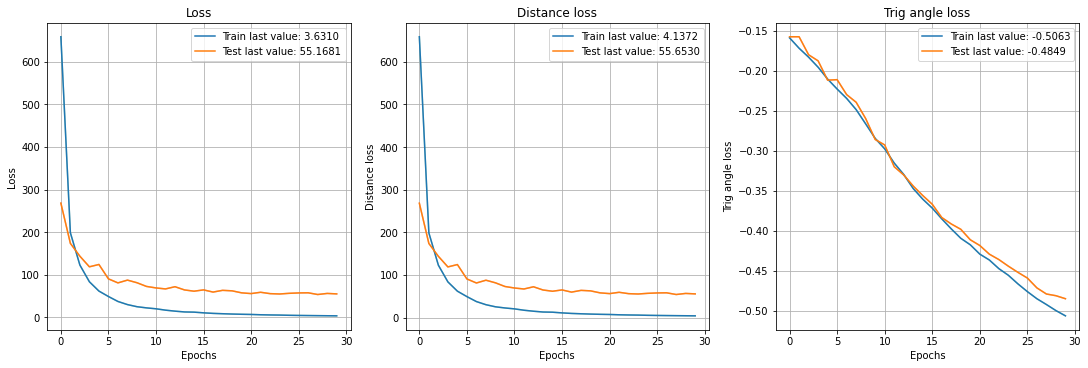

In [19]:
plot_history(dist_and_trig_model_history, path=f"{global_dirname}/results_history/{model_name}")

save_model(dist_and_trig_model, model_dir, model_name)

In [20]:

def aggregate_cos_distance(pred, target, aggregator=np.mean):
    return aggregator(np.matrix.diagonal(cosine_distances(pred, target)))
    

In [21]:
dist_pred, trig_angle = dist_and_trig_model.predict(test_generator_angle)

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_distances

print(trig_angle)
model_name = "img_bb+class~dist_feet+(cos_angle + sin_angle)"

update_metrics(img_metric_df, df_test, 
               (dist_pred, trig_angle),
               ("dist_feet", ["cos_angle", "sin_angle"]),
               (rmse, aggregate_cos_distance),
               "image+class_find~dist+cos+sin",
              epochs=epochs)

img_metric_df.to_csv(f"{data_dir}/metrics/model_metrics.csv")

img_metric_df

[[ 33.468395   -8.409894 ]
 [-21.505346    1.4056895]
 [ 56.380524  -40.988564 ]
 ...
 [ 23.554428  -32.13653  ]
 [ 27.642126  -16.054731 ]
 [-46.80458    16.320574 ]]
7.460093991469871
1.1770322332261818


,input_features,epochs,dist_feet_rmse_total,dist_feet_rmse_human,"['cos_angle', 'sin_angle']_aggregate_cos_distance_total","['cos_angle', 'sin_angle']_aggregate_cos_distance_human"
image+class_find~dist+cos+sin,NaN,30.0,7.460094,4.555254,1.177032,1.028046


# Subimage training with position

In [25]:
#needing to resset these 

#subimage position layers
subimage_pos_layer = keras.layers.Conv2D(500, kernel_size=3, activation="relu")(subimage_pos_input)
subimage_pos_layer = keras.layers.AveragePooling2D()(subimage_pos_layer)
subimage_pos_layer = keras.layers.Conv2D(250, kernel_size=3, activation="relu")(subimage_pos_layer)
subimage_pos_layer = keras.layers.AveragePooling2D()(subimage_pos_layer)
subimage_pos_layer = keras.layers.Flatten()(subimage_pos_layer)

#concatanate the two layers
combined_layer = keras.layers.concatenate([subimage_pos_layer, class_layer])
combined_layer = keras.layers.Dense(100, activation="relu")(combined_layer)
combined_layer = keras.layers.Dense(32, activation="relu")(combined_layer)

#output layers
dist_layer = keras.layers.Dense(1, name="distance")(combined_layer)
angle_layer = keras.layers.Dense(angle_shape[0], name="angle")(combined_layer)
trig_angle_layer = keras.layers.Dense(2, name="trig_angle")(combined_layer)

In [26]:
subimage_trig_model = keras.Model(
    inputs=[subimage_pos_input, class_input],
    outputs=[dist_layer, trig_angle_layer]
)

In [27]:
model_name = "subimage_w_position+class~dist_feet+(cos_angle + sin_angle)"

keras.utils.plot_model(subimage_trig_model, f"{global_dirname}/models/diagrams/{model_name}.png", show_shapes=True)

subimage_trig_model.compile(loss={"distance": 'mean_squared_error', "trig_angle": "cosine_similarity"}, 
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=0.00001))

#train the model
subimage_trig_model_history = subimage_trig_model.fit(train_subimage_pos_trig_generator, 
                                                      validation_data=test_subimage_pos_trig_generator,
                                                      batch_size=32,epochs=epochs, verbose=2)

Epoch 1/1000
3043/3043 - 227s - loss: 666.4493 - distance_loss: 666.4682 - trig_angle_loss: -1.8648e-02 - val_loss: 314.9242 - val_distance_loss: 315.0390 - val_trig_angle_loss: -1.1484e-01 - 227s/epoch - 75ms/step
Epoch 2/1000
3043/3043 - 223s - loss: 219.2270 - distance_loss: 219.3672 - trig_angle_loss: -1.4035e-01 - val_loss: 255.5182 - val_distance_loss: 255.6817 - val_trig_angle_loss: -1.6342e-01 - 223s/epoch - 73ms/step
Epoch 3/1000
3043/3043 - 224s - loss: 138.9524 - distance_loss: 139.1260 - trig_angle_loss: -1.7375e-01 - val_loss: 261.3174 - val_distance_loss: 261.4837 - val_trig_angle_loss: -1.6638e-01 - 224s/epoch - 74ms/step
Epoch 4/1000
3043/3043 - 220s - loss: 93.5251 - distance_loss: 93.7004 - trig_angle_loss: -1.7538e-01 - val_loss: 125.8679 - val_distance_loss: 126.0300 - val_trig_angle_loss: -1.6202e-01 - 220s/epoch - 72ms/step
Epoch 5/1000
3043/3043 - 220s - loss: 70.2536 - distance_loss: 70.4323 - trig_angle_loss: -1.7860e-01 - val_loss: 116.1853 - val_distance_loss

Epoch 40/1000
3043/3043 - 220s - loss: 2.2284 - distance_loss: 2.6571 - trig_angle_loss: -4.2869e-01 - val_loss: 61.9662 - val_distance_loss: 62.3692 - val_trig_angle_loss: -4.0294e-01 - 220s/epoch - 72ms/step
Epoch 41/1000
3043/3043 - 225s - loss: 2.1715 - distance_loss: 2.6052 - trig_angle_loss: -4.3372e-01 - val_loss: 63.7477 - val_distance_loss: 64.1538 - val_trig_angle_loss: -4.0621e-01 - 225s/epoch - 74ms/step
Epoch 42/1000
3043/3043 - 225s - loss: 2.0274 - distance_loss: 2.4653 - trig_angle_loss: -4.3785e-01 - val_loss: 61.7551 - val_distance_loss: 62.1633 - val_trig_angle_loss: -4.0811e-01 - 225s/epoch - 74ms/step
Epoch 43/1000
3043/3043 - 221s - loss: 1.9724 - distance_loss: 2.4150 - trig_angle_loss: -4.4259e-01 - val_loss: 62.5051 - val_distance_loss: 62.9166 - val_trig_angle_loss: -4.1154e-01 - 221s/epoch - 73ms/step
Epoch 44/1000
3043/3043 - 223s - loss: 1.8521 - distance_loss: 2.2995 - trig_angle_loss: -4.4743e-01 - val_loss: 61.3882 - val_distance_loss: 61.8041 - val_trig

3043/3043 - 220s - loss: 0.2777 - distance_loss: 0.8220 - trig_angle_loss: -5.4431e-01 - val_loss: 60.2563 - val_distance_loss: 60.7335 - val_trig_angle_loss: -4.7726e-01 - 220s/epoch - 72ms/step
Epoch 80/1000
3043/3043 - 220s - loss: 0.2515 - distance_loss: 0.7976 - trig_angle_loss: -5.4614e-01 - val_loss: 59.9776 - val_distance_loss: 60.4552 - val_trig_angle_loss: -4.7759e-01 - 220s/epoch - 72ms/step
Epoch 81/1000
3043/3043 - 220s - loss: 0.2578 - distance_loss: 0.8060 - trig_angle_loss: -5.4826e-01 - val_loss: 60.3372 - val_distance_loss: 60.8167 - val_trig_angle_loss: -4.7948e-01 - 220s/epoch - 72ms/step
Epoch 82/1000
3043/3043 - 220s - loss: 0.2184 - distance_loss: 0.7684 - trig_angle_loss: -5.4997e-01 - val_loss: 60.8911 - val_distance_loss: 61.3690 - val_trig_angle_loss: -4.7780e-01 - 220s/epoch - 72ms/step
Epoch 83/1000
3043/3043 - 220s - loss: 0.2182 - distance_loss: 0.7704 - trig_angle_loss: -5.5223e-01 - val_loss: 60.0124 - val_distance_loss: 60.4917 - val_trig_angle_loss: -

Epoch 118/1000
3043/3043 - 239s - loss: -2.0473e-01 - distance_loss: 0.3987 - trig_angle_loss: -6.0344e-01 - val_loss: 59.2308 - val_distance_loss: 59.7361 - val_trig_angle_loss: -5.0523e-01 - 239s/epoch - 78ms/step
Epoch 119/1000
3043/3043 - 239s - loss: -1.9971e-01 - distance_loss: 0.4049 - trig_angle_loss: -6.0458e-01 - val_loss: 59.5349 - val_distance_loss: 60.0407 - val_trig_angle_loss: -5.0586e-01 - 239s/epoch - 78ms/step
Epoch 120/1000
3043/3043 - 240s - loss: -2.2070e-01 - distance_loss: 0.3855 - trig_angle_loss: -6.0618e-01 - val_loss: 59.6007 - val_distance_loss: 60.1071 - val_trig_angle_loss: -5.0644e-01 - 240s/epoch - 79ms/step
Epoch 121/1000
3043/3043 - 239s - loss: -1.9944e-01 - distance_loss: 0.4080 - trig_angle_loss: -6.0747e-01 - val_loss: 59.4026 - val_distance_loss: 59.9078 - val_trig_angle_loss: -5.0528e-01 - 239s/epoch - 79ms/step
Epoch 122/1000
3043/3043 - 235s - loss: -2.2983e-01 - distance_loss: 0.3788 - trig_angle_loss: -6.0866e-01 - val_loss: 59.6030 - val_dis

Epoch 156/1000
3043/3043 - 240s - loss: -3.9675e-01 - distance_loss: 0.2456 - trig_angle_loss: -6.4237e-01 - val_loss: 59.2386 - val_distance_loss: 59.7564 - val_trig_angle_loss: -5.1779e-01 - 240s/epoch - 79ms/step
Epoch 157/1000
3043/3043 - 239s - loss: -4.1170e-01 - distance_loss: 0.2314 - trig_angle_loss: -6.4307e-01 - val_loss: 59.2922 - val_distance_loss: 59.8105 - val_trig_angle_loss: -5.1828e-01 - 239s/epoch - 79ms/step
Epoch 158/1000
3043/3043 - 237s - loss: -4.0289e-01 - distance_loss: 0.2412 - trig_angle_loss: -6.4405e-01 - val_loss: 59.3460 - val_distance_loss: 59.8652 - val_trig_angle_loss: -5.1913e-01 - 237s/epoch - 78ms/step
Epoch 159/1000
3043/3043 - 236s - loss: -4.0715e-01 - distance_loss: 0.2374 - trig_angle_loss: -6.4460e-01 - val_loss: 59.4140 - val_distance_loss: 59.9340 - val_trig_angle_loss: -5.1996e-01 - 236s/epoch - 78ms/step
Epoch 160/1000
3043/3043 - 236s - loss: -4.1723e-01 - distance_loss: 0.2285 - trig_angle_loss: -6.4571e-01 - val_loss: 59.2937 - val_dis

Epoch 194/1000
3043/3043 - 221s - loss: -5.0668e-01 - distance_loss: 0.1648 - trig_angle_loss: -6.7150e-01 - val_loss: 59.4204 - val_distance_loss: 59.9511 - val_trig_angle_loss: -5.3074e-01 - 221s/epoch - 73ms/step
Epoch 195/1000
3043/3043 - 221s - loss: -5.1035e-01 - distance_loss: 0.1619 - trig_angle_loss: -6.7226e-01 - val_loss: 58.8521 - val_distance_loss: 59.3826 - val_trig_angle_loss: -5.3059e-01 - 221s/epoch - 73ms/step
Epoch 196/1000
3043/3043 - 221s - loss: -5.1328e-01 - distance_loss: 0.1595 - trig_angle_loss: -6.7277e-01 - val_loss: 58.9429 - val_distance_loss: 59.4740 - val_trig_angle_loss: -5.3122e-01 - 221s/epoch - 73ms/step
Epoch 197/1000
3043/3043 - 221s - loss: -5.1916e-01 - distance_loss: 0.1542 - trig_angle_loss: -6.7331e-01 - val_loss: 58.9907 - val_distance_loss: 59.5222 - val_trig_angle_loss: -5.3140e-01 - 221s/epoch - 73ms/step
Epoch 198/1000
3043/3043 - 221s - loss: -5.2338e-01 - distance_loss: 0.1506 - trig_angle_loss: -6.7395e-01 - val_loss: 58.9269 - val_dis

Epoch 232/1000
3043/3043 - 221s - loss: -5.7445e-01 - distance_loss: 0.1187 - trig_angle_loss: -6.9313e-01 - val_loss: 58.7097 - val_distance_loss: 59.2494 - val_trig_angle_loss: -5.3972e-01 - 221s/epoch - 73ms/step
Epoch 233/1000
3043/3043 - 221s - loss: -5.7995e-01 - distance_loss: 0.1139 - trig_angle_loss: -6.9383e-01 - val_loss: 58.7179 - val_distance_loss: 59.2588 - val_trig_angle_loss: -5.4080e-01 - 221s/epoch - 73ms/step
Epoch 234/1000
3043/3043 - 221s - loss: -5.7934e-01 - distance_loss: 0.1150 - trig_angle_loss: -6.9432e-01 - val_loss: 59.0967 - val_distance_loss: 59.6380 - val_trig_angle_loss: -5.4130e-01 - 221s/epoch - 73ms/step
Epoch 235/1000
3043/3043 - 221s - loss: -5.7984e-01 - distance_loss: 0.1152 - trig_angle_loss: -6.9502e-01 - val_loss: 58.8151 - val_distance_loss: 59.3564 - val_trig_angle_loss: -5.4135e-01 - 221s/epoch - 73ms/step
Epoch 236/1000
3043/3043 - 221s - loss: -5.8451e-01 - distance_loss: 0.1106 - trig_angle_loss: -6.9510e-01 - val_loss: 59.0054 - val_dis

Epoch 270/1000
3043/3043 - 221s - loss: -6.2500e-01 - distance_loss: 0.0869 - trig_angle_loss: -7.1189e-01 - val_loss: 58.9348 - val_distance_loss: 59.4824 - val_trig_angle_loss: -5.4770e-01 - 221s/epoch - 73ms/step
Epoch 271/1000
3043/3043 - 221s - loss: -6.2388e-01 - distance_loss: 0.0885 - trig_angle_loss: -7.1243e-01 - val_loss: 58.8293 - val_distance_loss: 59.3770 - val_trig_angle_loss: -5.4766e-01 - 221s/epoch - 73ms/step
Epoch 272/1000
3043/3043 - 221s - loss: -6.2870e-01 - distance_loss: 0.0839 - trig_angle_loss: -7.1257e-01 - val_loss: 58.6655 - val_distance_loss: 59.2143 - val_trig_angle_loss: -5.4873e-01 - 221s/epoch - 73ms/step
Epoch 273/1000
3043/3043 - 221s - loss: -6.2759e-01 - distance_loss: 0.0856 - trig_angle_loss: -7.1316e-01 - val_loss: 58.8407 - val_distance_loss: 59.3882 - val_trig_angle_loss: -5.4748e-01 - 221s/epoch - 73ms/step
Epoch 274/1000
3043/3043 - 221s - loss: -6.2662e-01 - distance_loss: 0.0870 - trig_angle_loss: -7.1365e-01 - val_loss: 58.7939 - val_dis

Epoch 308/1000
3043/3043 - 221s - loss: -6.5526e-01 - distance_loss: 0.0720 - trig_angle_loss: -7.2725e-01 - val_loss: 58.9225 - val_distance_loss: 59.4755 - val_trig_angle_loss: -5.5302e-01 - 221s/epoch - 73ms/step
Epoch 309/1000
3043/3043 - 221s - loss: -6.5933e-01 - distance_loss: 0.0685 - trig_angle_loss: -7.2780e-01 - val_loss: 59.0683 - val_distance_loss: 59.6211 - val_trig_angle_loss: -5.5274e-01 - 221s/epoch - 73ms/step
Epoch 310/1000
3043/3043 - 221s - loss: -6.6261e-01 - distance_loss: 0.0654 - trig_angle_loss: -7.2798e-01 - val_loss: 58.8553 - val_distance_loss: 59.4087 - val_trig_angle_loss: -5.5351e-01 - 221s/epoch - 73ms/step
Epoch 311/1000
3043/3043 - 221s - loss: -6.6304e-01 - distance_loss: 0.0653 - trig_angle_loss: -7.2833e-01 - val_loss: 58.9352 - val_distance_loss: 59.4881 - val_trig_angle_loss: -5.5295e-01 - 221s/epoch - 73ms/step
Epoch 312/1000
3043/3043 - 221s - loss: -6.5818e-01 - distance_loss: 0.0704 - trig_angle_loss: -7.2856e-01 - val_loss: 59.0252 - val_dis

Epoch 346/1000
3043/3043 - 221s - loss: -6.8273e-01 - distance_loss: 0.0581 - trig_angle_loss: -7.4078e-01 - val_loss: 58.9813 - val_distance_loss: 59.5366 - val_trig_angle_loss: -5.5531e-01 - 221s/epoch - 73ms/step
Epoch 347/1000
3043/3043 - 221s - loss: -6.8773e-01 - distance_loss: 0.0534 - trig_angle_loss: -7.4112e-01 - val_loss: 58.8561 - val_distance_loss: 59.4120 - val_trig_angle_loss: -5.5588e-01 - 221s/epoch - 73ms/step
Epoch 348/1000
3043/3043 - 221s - loss: -6.8860e-01 - distance_loss: 0.0529 - trig_angle_loss: -7.4151e-01 - val_loss: 58.9494 - val_distance_loss: 59.5054 - val_trig_angle_loss: -5.5600e-01 - 221s/epoch - 73ms/step
Epoch 349/1000
3043/3043 - 221s - loss: -6.8624e-01 - distance_loss: 0.0557 - trig_angle_loss: -7.4192e-01 - val_loss: 58.9713 - val_distance_loss: 59.5267 - val_trig_angle_loss: -5.5539e-01 - 221s/epoch - 73ms/step
Epoch 350/1000
3043/3043 - 221s - loss: -6.8753e-01 - distance_loss: 0.0546 - trig_angle_loss: -7.4214e-01 - val_loss: 58.9025 - val_dis

KeyboardInterrupt: 

In [28]:
plot_history(subimage_trig_model_history, path=f"{global_dirname}/results_history/{model_name}")

save_model(subimage_trig_model, model_dir, model_name)

NameError: name 'subimage_trig_model_history' is not defined

In [ ]:
dist_pred, trig_angle = subimage_trig_model.predict(test_subimage_pos_trig_generator)

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_distances

print(trig_angle)

update_metrics(img_metric_df, df_test, 
               (dist_pred, trig_angle),
               ("dist_feet", ["cos_angle", "sin_angle"]),
               (rmse, aggregate_cos_distance),
               model_name,
              epochs=epochs)

img_metric_df.to_csv(f"{data_dir}/metrics/model_metrics.csv")

img_metric_df

# Subimage Training with no position

In [18]:
#subimage no position
subimage_no_pos_layer = keras.layers.Conv2D(500, kernel_size=3, activation="relu", padding="same")(subimage_no_pos_input)
subimage_no_pos_layer = keras.layers.AveragePooling2D()(subimage_no_pos_layer)
subimage_no_pos_layer = keras.layers.Conv2D(250, kernel_size=3, activation="relu",padding="same")(subimage_no_pos_layer)
subimage_no_pos_layer = keras.layers.AveragePooling2D()(subimage_no_pos_layer)
subimage_no_pos_layer = keras.layers.Flatten()(subimage_no_pos_layer)



#position layers
position_layer = keras.layers.Dense(6, kernel_initializer='normal', activation='relu')(position_input)
position_layer = keras.layers.Dense(5, kernel_initializer='normal', activation='relu')(position_layer)
position_layer = keras.layers.Dense(2, kernel_initializer='normal', activation='relu')(position_layer)


#concatanate the two layers
combined_layer = keras.layers.concatenate([subimage_no_pos_layer, class_layer, position_layer])


combined_layer = keras.layers.Dense(100, activation="relu")(combined_layer)
combined_layer = keras.layers.Dense(32, activation="relu")(combined_layer)

#output layers
dist_layer = keras.layers.Dense(1, name="distance")(combined_layer)
angle_layer = keras.layers.Dense(angle_shape[0], name="angle")(combined_layer)
trig_angle_layer = keras.layers.Dense(2, name="trig_angle")(combined_layer)

In [ ]:
print(subimage_no_pos_shape, subimage_pos_shape)

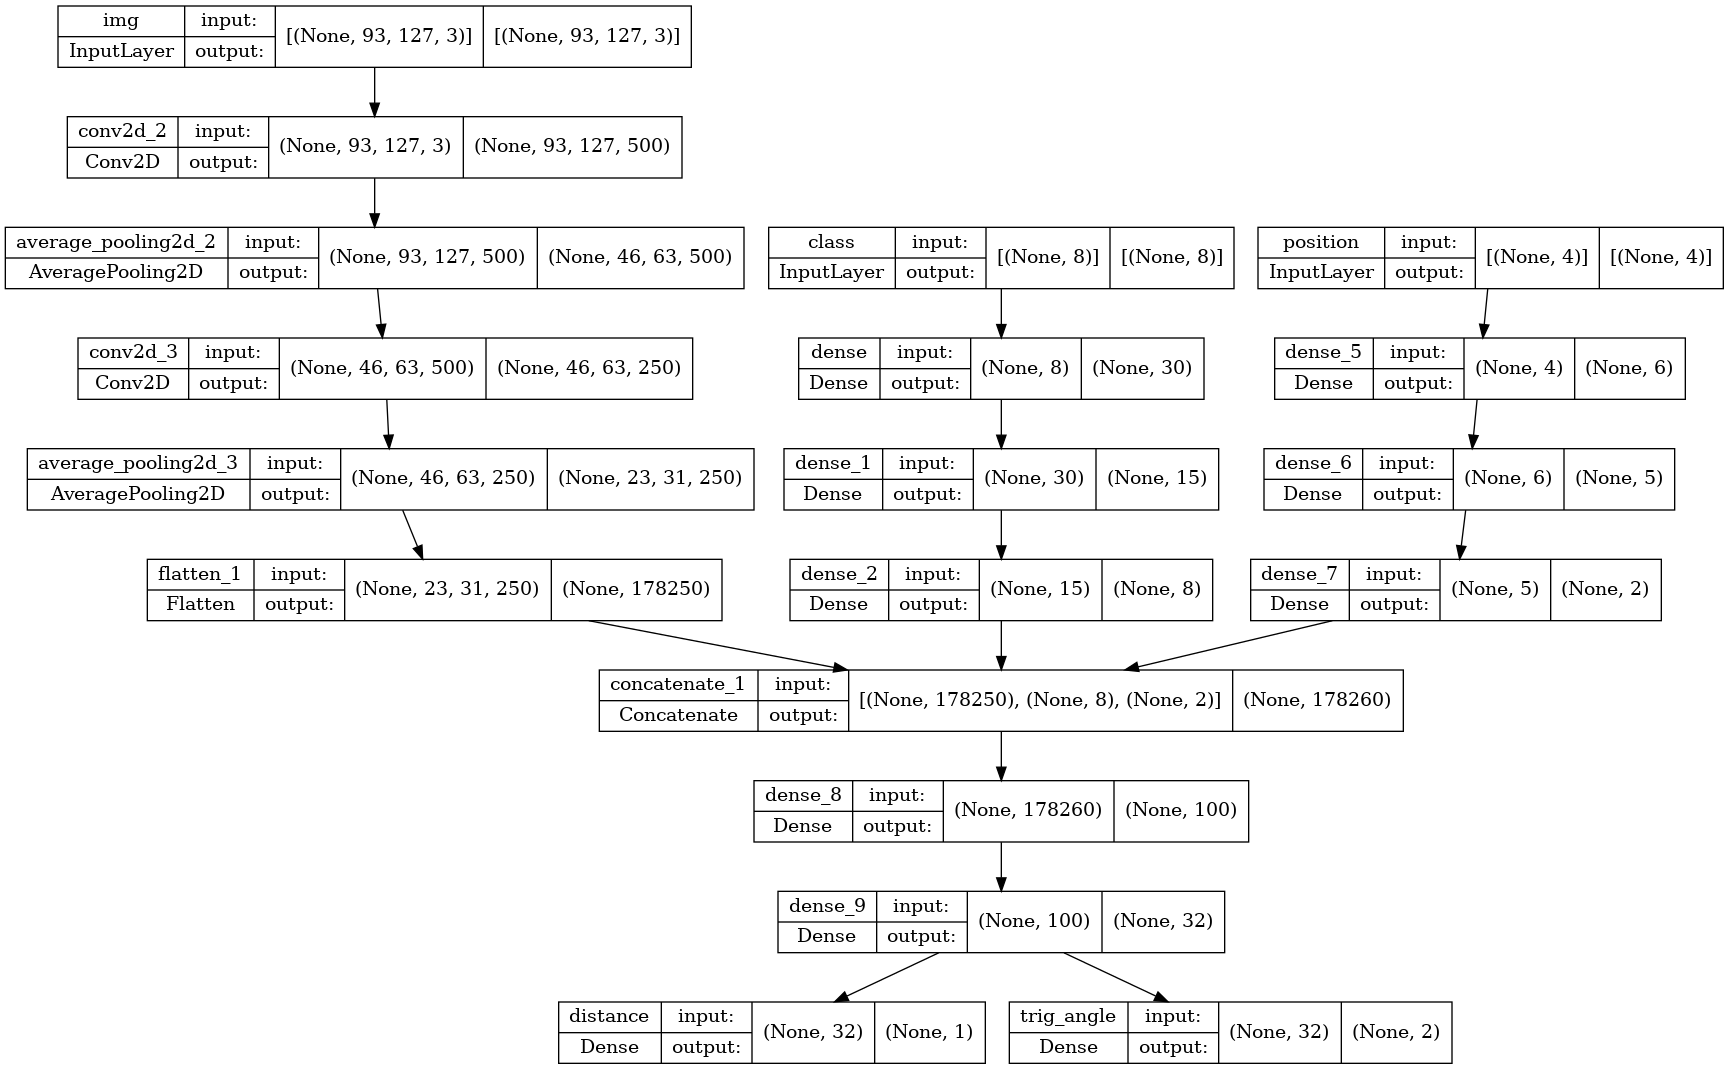

In [20]:
model_name = "class+position~dist+trig"

subimage_trig_model = keras.Model(
    inputs=[subimage_no_pos_input, class_input, position_input],
    outputs=[dist_layer, trig_angle_layer]
)

keras.utils.plot_model(subimage_trig_model, f"{global_dirname}/models/diagrams/{model_name}.png", show_shapes=True)


In [2]:
model_name = "subimage_no_position+[xmin+xmax+ymin+ymax]+class~dist_feet+(cos_angle + sin_angle)"

keras.utils.plot_model(subimage_trig_model, f"{global_dirname}/models/diagrams/{model_name}.png", show_shapes=True)

subimage_trig_model.compile(loss={"distance": 'mean_squared_error', "trig_angle": "cosine_similarity"}, 
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=0.00001))

#train the model
subimage_trig_model_history = subimage_trig_model.fit(train_subimage_no_pos_trig_generator, 
                                                      validation_data=test_subimage_no_pos_trig_generator,
                                                      batch_size=32,epochs=epochs, verbose=2)

NameError: name 'subimage_trig_model' is not defined

In [ ]:
plot_history(subimage_trig_model_history, path=f"{global_dirname}/results_history/{model_name}")

save_model(subimage_trig_model, model_dir, model_name)

In [ ]:
dist_pred, trig_angle = subimage_trig_model.predict(test_subimage_pos_trig_generator)

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_distances

print(trig_angle)

update_metrics(img_metric_df, df_test, 
               (dist_pred, trig_angle),
               ("dist_feet", ["cos_angle", "sin_angle"]),
               (rmse, aggregate_cos_distance),
               model_name,
              epochs=epochs)

img_metric_df.to_csv(f"{data_dir}/metrics/model_metrics.csv")

img_metric_df